# Can an open-ended question asking to imagine the future help predict future health? Text mining analysis in the 1956 National Child Development Study.

#### By Thierry Gagné
#### First created April 13th, 2023; Last updated April 20th, 2023.

# 1. GOAL

This project aims to analyse the text data from the answers of participants in the National Child Development Study, who were asked at age 50 to imagine their future at the age of 60. 

The **first** part produces abstract variables based on the text data for further analyses.

These includes 1) whether they provided any response, 2) the word count, 3) the readibility score, 4)whether certain **tokens** are more common.

Inspired by Weber (2021), I tried to also extract topics using Latent Dirichlet Allocation (LDA), but after spending 5-10 hours on the project, I realised LDA is really not adapted for short texts that rapidly touch multiple topics.

The **second** part opens the main survey at ages 50 (2008) and 62 (2021), and explores whether the extracted text data is related with participants' current and future health.

Cheers,

Thierry



### REFERENCES


Power & Elliott (2006)

https://academic.oup.com/ije/article/35/1/34/849767

Elliott (2012)

https://cls.ucl.ac.uk/wp-content/uploads/2017/07/NCDS-User-Guide-Imagine-you-are-60-qualitative-dataset-J-Elliott-June-2012.pdf

Weber (2021)

https://journals.sagepub.com/doi/full/10.1177/21582440211061567

Elliott (2022)

https://nsuworks.nova.edu/tqr/vol27/iss6/14/

UK Data Service 

https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=6978

Wikipedia entry on the "Flesch reading ease" score

https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_Reading_Ease





# 1. OPENING AND CLEANING DATA

## 1.1 SETTING UP THE DATA 

This includes calculating a readibility score on the raw text data



In [331]:
# pip install readability
# pip install nltk
# !pip install gensim

In [73]:
import numpy as np
import pandas as pd
import readability
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_colwidth = 100

df = pd.read_csv("ncds8_imagine_text.tab", sep='\t', lineterminator='\r', encoding='cp1252')
df["response"] = np.where(df["IMAGINE"].isna() == True, 0, 1)
df["NCDSID"] = df["NCDSID"].str.findall("N[\w]*").astype(str)
df["NCDSID"] = df["NCDSID"].str.replace("[", "")
df["NCDSID"] = df["NCDSID"].str.replace("'", "")
df["NCDSID"] = df["NCDSID"].str.replace("]", "")
cols = df.columns.tolist()
cols = [cols[0], cols[2], cols[3], cols[1]]
df = df[cols]
df["IMAGINE"] = df["IMAGINE"].astype(str)
df["IMAGINE"] = np.where(df["IMAGINE"] == "nan", "", df["IMAGINE"])
df["readability"] = df.apply(lambda x: readability.getmeasures(x["IMAGINE"], lang='en')['readability grades']['FleschReadingEase'] if x["IMAGINE"] != "" else None, axis=1)
df.head()

print(sum(df["WORDCNT"].dropna()))


423763.0


## 1.2 CLEANING TEXT

The goal of this step is to go from the raw text to a set of tokens for analysis.

We use stemming to create unique tokens from different words with the same root, e.g., happy and happiness = happi.

**CAVEATS**

This cleaning cannot: 1) aim to capture and correct misspellings (e.g., proberli instead of probably); 2) deduce whether something relates to the past, present, or future (e.g., someone writing that they are retired now versus that they are looking forward to retirement later); 3) know the relationship between tokens (e.g., "happi" may refer to the participant's own happiness or their children's).

**N.B. Takes 5-10 seconds to run**.

In [2]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

df["IMAGINE_clean"] = df["IMAGINE"].str.lower()

### REMOVING STOPWORDS

for a in stopwords.words('english'):
    x = " " + a + " "
    y = "^" + a + " "
    z = " " + a + "$"
    df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace(x, " ")
    df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace(y, " ")
    df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace(z, " ")
    
### REMOVING OTHER NOISE LIKE NUMBERS, SYMBOLS, AND THE WORD "year"

df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\{(.*?)\}", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\[(.*?)\]", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\"", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\d", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\.", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\!", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\,", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\@", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("-", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\:", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\&", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\(", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\)", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\+", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\;", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\?", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\/", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\'", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\#", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\%", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\*", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\=", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\'", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\{", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\~", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\£", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\–", " ")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("…", " ")
    
for x in range(3):
    df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("  ", " ")

### REPLACING WORDS BY THEIR STEM

porter = nltk.PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['IMAGINE_clean'] = df['IMAGINE_clean'].apply(stem_sentences)

### REMOVING THOSE LAST PESKY WORDS (e.g., the stemmed token year could have been YEARS)

df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\bsixti\\b", "")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\byear\\b", "")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\bstill\\b", "")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\bwould\\b", "")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("\\bold\\b", "")
df['IMAGINE_clean'] = df['IMAGINE_clean'].str.replace("  ", " ")

df[["IMAGINE", "IMAGINE_clean"]].head()

,IMAGINE,IMAGINE_clean
0,I am very happy & content with life at the moment and can see no change within the next ten year...,happi content life moment see chang within next ten hope work might downsiz hous may also grandc...
1,"I hope to be semi-retired spending the UK winter months in South Africa. As an older parent, I h...",hope semi retir spend uk winter month south africa older parent hope steer daughter final educ i...
2,"I hope I will still be riding horses, taking good holidays. I would like to be working part time...",hope ride hors take good holiday like work part time live hous marri husband
3,"MY INTERESTS ARE HOME WINE & BEER BREWING, WHEN I GET AN ALLOTMENT, GROWING MY OWN VEGETABLES. @...",interest home wine beer brew get allot grow veget home life ten ago health okay except knee s pl...
4,"I AM 60 YEARS OLD, IN GOOD HEALTH AND HAVE A JOB I ENJOY. I HAVE MANY INTERESTS IN MY SPARE TIME...",good health job enjoy mani interest spare time choos retir mani thing keep busi ago start build...


## 1.3 REDUCING THE DATASET

Data cleaning is art rather than science. However, this cleaning step will try to copy the steps made by Weber (2021).

This means: 1) removing tokens with less than three letters, 2) removing tokens that appear less than 5 times across the whole corpus, and 3) removing entries with less than five valid tokens.

**Removing infrequent tokens requires a good 2-3 minutes to run, please be patient!**

In [3]:
######################################################
# 1. REMOVING TOKENS WITH LESS THAN THREE LETTERS.
######################################################

print("REMOVING TOKENS WITH LESS THAN THREE LETTERS...\n".lower())

def cleanup_fewerthanthreeletters(data):
    data = data.split(" ")
    newdata = []
    for x in data:
        if len(x) >= 3:
            newdata.append(x)
    return (" ").join(newdata)

df['IMAGINE_reduced'] = df['IMAGINE_clean'].apply(cleanup_fewerthanthreeletters)

######################################################
# 2. REMOVING TOKENS USED LESS THAN 5 TIMES ACROSS THE CORPUS
######################################################

print("CREATING A DICTIONARY OF THE FREQUENCY OF ALL UNIQUE TOKENS (takes 2-3 minutes)...\n".lower())

# This requires:
    # First making a uniquetokens
    # Second, making a dictionary with their count
    # Reducing this to a word list of those with fewer than 25 occurences.
    # Finally, filtering through all entries to remove these words.

# MAKING A UNIQUETOKENS VARIABLE

# This create a single list of strings instance.
list_texts = []
for x in df['IMAGINE_reduced']:
    list_texts.append(x)

# This create a single long string instance.
longstring = " ".join(list_texts)

# The first step is to create a list of unique words
uniquetokens = sorted(list(set(longstring.split())))

# print(len(uniquetokens))

# MAKING A DICTIONARY OF FREQUENCY

dict_absfreq = {}
for counttimer, a in enumerate(uniquetokens):
    count = 0
    for b in df['IMAGINE_reduced']:
        text = "\\b" + a + "\\b"
        if len(re.findall(text, b)) >= 1:
                count += len(re.findall(text, b))
                dict_absfreq[a] = count
    if counttimer > 0 and counttimer % 500 == 0:
        print(counttimer, "out of", len(uniquetokens), "tokens done.")
        
print(counttimer+1, "entries done.\n")
print("Now, run the next cell!")

removing tokens with less than three letters...

creating a dictionary of the frequency of all unique tokens (takes 2-3 minutes)...

500 out of 6531 tokens done.
1000 out of 6531 tokens done.
1500 out of 6531 tokens done.
2000 out of 6531 tokens done.
2500 out of 6531 tokens done.
3000 out of 6531 tokens done.
3500 out of 6531 tokens done.
4000 out of 6531 tokens done.
4500 out of 6531 tokens done.
5000 out of 6531 tokens done.
5500 out of 6531 tokens done.
6000 out of 6531 tokens done.
6500 out of 6531 tokens done.
6531 entries done.

Now, run the next cell!


In [4]:
# Now that we have calculated the frequency of all unique tokens ...

list_absfreq = sorted(dict_absfreq.items(), key=lambda x:x[1], reverse = True)

print("The top five most frequent tokens are:\n")

print(list_absfreq[:5], "\n")

# YOU CAN DECIDE HERE HOW MANY TIMES YOU NEED TO SEE A TOKEN TO INCLUDE IT IN YOUR PROJECT
limitforminfreq = 5

list_absfreq_lessthan = []
for x, y in list_absfreq:
    if y < limitforminfreq:
        list_absfreq_lessthan.append(x)

print("Five examples of tokens present less than {} times: \n".format(limitforminfreq)) 

print(list_absfreq_lessthan[:limitforminfreq], "\n")

print("REMOVING TOKENS WITH LESS THAN {} OCCURENCES (takes 5-10 seconds)...\n".format(limitforminfreq).lower())

def cleanup_fewerthan(data):
    data = data.split(" ")
    newdata = []
    for x in data:
        if x not in list_absfreq_lessthan:
            newdata.append(x)
    return (" ").join(newdata)

df['IMAGINE_reduced'] = df['IMAGINE_reduced'].apply(cleanup_fewerthan)

######################################################
# 3. REMOVING ENTRIES WITH LESS THAN FIVE VALID TOKENS
######################################################

print("DELETING ENTRIES ENTRIES WITH LESS THAN FIVE VALID TOKENS...\n".lower())

def cleanup_fewerthanfive(data):
    data = data.split(" ")
    if len(data) < 5:
        data = ""
    return (" ").join(data)

df['IMAGINE_reduced'] = df['IMAGINE_reduced'].apply(cleanup_fewerthanfive)

print("Voila!...\n")

df[["IMAGINE_clean", "IMAGINE_reduced"]].head(10)

The top five most frequent tokens are:

[('work', 5790), ('time', 5283), ('hope', 4861), ('enjoy', 3492), ('health', 3442)] 

Five examples of tokens present less than 5 times: 

['abus', 'advisor', 'aircraft', 'alright', 'amen'] 

removing tokens with less than 5 occurences (takes 5-10 seconds)...

deleting entries entries with less than five valid tokens...

Voila!...



,IMAGINE_clean,IMAGINE_reduced
0,happi content life moment see chang within next ten hope work might downsiz hous may also grandc...,happi content life moment see chang within next ten hope work might downsiz hous may also grandc...
1,hope semi retir spend uk winter month south africa older parent hope steer daughter final educ i...,hope semi retir spend winter month south africa older parent hope daughter final educ expect ene...
2,hope ride hors take good holiday like work part time live hous marri husband,hope ride hors take good holiday like work part time live hous marri husband
3,interest home wine beer brew get allot grow veget home life ten ago health okay except knee s pl...,interest home wine beer get allot grow veget home life ten ago health okay except knee play bit ...
4,good health job enjoy mani interest spare time choos retir mani thing keep busi ago start build...,good health job enjoy mani interest spare time choos retir mani thing keep busi ago start build ...
5,hope work civil servic continu lead rel normal life although mobil deterior imagin live alon son...,hope work civil servic continu lead rel normal life although mobil deterior imagin live alon son...
6,dont look futur much know time hope aliv know,dont look futur much know time hope aliv know
7,ask,
8,,
9,like think life less now,like think life less now


# 2. FINDING THE MOST COMMON WORD TOKENS

The goal here is to create a list of the most frequent tokens used across texts.

## 2.1 ABSOLUTE FREQUENCY

In [6]:
list_absfreq


[('work', 4316),
 ('time', 3365),
 ('health', 3151),
 ('hope', 3067),
 ('life', 2579),
 ('enjoy', 2476),
 ('retir', 2452),
 ('good', 2319),
 ('children', 1996),
 ('live', 1915),
 ('famili', 1741),
 ('home', 1620),
 ('walk', 1452),
 ('grandchildren', 1364),
 ('like', 1347),
 ('holiday', 1331),
 ('husband', 1323),
 ('travel', 1259),
 ('friend', 1237),
 ('spend', 1209),
 ('healthi', 1174),
 ('part', 1173),
 ('interest', 1136),
 ('happi', 1134),
 ('activ', 1108),
 ('job', 1098),
 ('abl', 1072),
 ('garden', 1059),
 ('look', 1043),
 ('fit', 966),
 ('wife', 868),
 ('keep', 859),
 ('marri', 848),
 ('take', 847),
 ('hous', 843),
 ('well', 820),
 ('see', 789),
 ('much', 768),
 ('thing', 766),
 ('play', 743),
 ('visit', 719),
 ('lot', 717),
 ('continu', 683),
 ('full', 663),
 ('also', 662),
 ('now', 659),
 ('get', 652),
 ('money', 650),
 ('love', 642),
 ('may', 627),
 ('day', 612),
 ('partner', 607),
 ('probabl', 598),
 ('think', 597),
 ('feel', 585),
 ('help', 569),
 ('possibl', 563),
 ('mayb', 

In [5]:
print("There are now", len(df[df['IMAGINE_reduced']!=""]), "valid entries.\n")
print("Recreating the uniquetokens list in the reduced dataset...\n")

# This create a single list of strings instance.
list_texts = []
for x in df['IMAGINE_reduced']:
    list_texts.append(x)

# This create a single long string instance.
longstring = " ".join(list_texts)

# The first step is to create a list of unique words
uniquetokens = sorted(list(set(longstring.split())))

print("There are", len(uniquetokens), "unique tokens now.\n")

print("Counting the presence of remaining tokens in the reduced dataset...\n")

dict_absfreq = {}
for counttimer, a in enumerate(uniquetokens):
    count = 0
    for b in df['IMAGINE_reduced']:
        text = "\\b" + a + "\\b"
        if len(re.findall(text, b)) >= 1:
                count += 1
                dict_absfreq[a] = count
    if counttimer > 0 and counttimer % 200 == 0:
        print(counttimer, "out of", len(uniquetokens), "tokens done.")
        
print(counttimer+1, "tokens done.\n")

list_absfreq = sorted(dict_absfreq.items(), key=lambda x:x[1], reverse = True)
# list_absfreq[:50]
list_absfreq_names = []
list_absfreq_numbers = []
for x in list_absfreq:
    list_absfreq_names.append(x[0])
    list_absfreq_numbers.append(x[1])

print("The top 50 most frequent tokens are...\n")
for x in list_absfreq_names[:50]:
    print(x)
list_absfreq_prop = [val/len(df[df['IMAGINE_reduced']!=""]) for val in list_absfreq_numbers]

print("\nThe prevalence of the 50 most frequent tokens is...\n")
for x in list_absfreq_prop[:50]:
    print(x)

There are now 7042 valid entries.

Recreating the uniquetokens list in the reduced dataset...

There are 2146 unique tokens now.

Counting the presence of remaining tokens in the reduced dataset...

200 out of 2146 tokens done.
400 out of 2146 tokens done.
600 out of 2146 tokens done.
800 out of 2146 tokens done.
1000 out of 2146 tokens done.
1200 out of 2146 tokens done.
1400 out of 2146 tokens done.
1600 out of 2146 tokens done.
1800 out of 2146 tokens done.
2000 out of 2146 tokens done.
2146 tokens done.

The top 50 most frequent tokens are...

work
time
health
hope
life
enjoy
retir
good
children
live
famili
home
walk
grandchildren
like
holiday
husband
travel
friend
spend
healthi
part
interest
happi
activ
job
abl
garden
look
fit
wife
keep
marri
take
hous
well
see
much
thing
play
visit
lot
continu
full
also
now
get
money
love
may

The prevalence of the 50 most frequent tokens is...

0.6128940641863108
0.47784720249928997
0.4474581084919057
0.4355296790684465
0.36623118432263563
0.351

## 2.2 RELATIVE FREQUENCY

I also re-use Weber (2021)'s focus on relative frequency instead of absolute. His argument was that the text length is not random, and some tokens may have a higher likelihood to appear in some groups simply because these groups tend to write longer texts. I therefore calculated the relative presence of a given token within a cleaned text sample, and then the mean of these proportions across all valid texts. 

I note that another way to deal with this is simply to control for word count in the main analyses, something that Weber did not do. Therefore, I only examine this second definition as a sensitivity analysis.

In [520]:
print("Counting the RELATIVE frequency of tokens in the reduced dataset...\n")

dict_relfreq = {}
for counttimer, a in enumerate(uniquetokens):
    count = 0
    for b in df['IMAGINE_reduced']:
        if b != "":
            text = "\\b" + a + "\\b"
            val1 = len(re.findall(text, b))
            val2 = len(b.split(" "))
            if val1 >= 1:
                    count += (val1 / val2)
            # print(val1, val2)
    dict_relfreq[a] = count/len(df[df["IMAGINE_reduced"]!=""])        
    if counttimer > 0 and counttimer % 200 == 0:
        print(counttimer, "out of", len(uniquetokens), "tokens done.")
        
print(counttimer+1, "tokens done.\n")

list_relfreq = sorted(dict_relfreq.items(), key=lambda x:x[1], reverse = True)

list_relfreq_names = []
list_relfreq_numbers = []

for x in list_relfreq:
    list_relfreq_names.append(x[0])
    list_relfreq_numbers.append(x[1])

print("The 50 tokens with the highest relative frequency are...\n")
for x in list_relfreq_names[:50]:
    print(x)

print("\nThe average relative frequency of the 50 most frequent tokens are...\n")
for x in list_relfreq_numbers[:50]:
    print(x)

Counting the RELATIVE frequency of tokens in the reduced dataset...

200 out of 2146 tokens done.
400 out of 2146 tokens done.
600 out of 2146 tokens done.
800 out of 2146 tokens done.
1000 out of 2146 tokens done.
1200 out of 2146 tokens done.
1400 out of 2146 tokens done.
1600 out of 2146 tokens done.
1800 out of 2146 tokens done.
2000 out of 2146 tokens done.
2146 tokens done.

The 50 tokens with the highest relative frequency are...

work
hope
time
health
life
enjoy
retir
good
live
children
famili
like
home
grandchildren
healthi
holiday
happi
walk
husband
travel
spend
abl
job
interest
activ
friend
part
look
garden
fit
marri
wife
much
thing
well
keep
hous
play
take
see
now
lot
think
continu
day
probabl
full
visit
money
get

The average relative frequency of the 50 most frequent tokens are...

0.03499474805101303
0.030388806990588397
0.02831269102265136
0.02246311631271905
0.020676483090531377
0.019926369585744685
0.017900544121149817
0.017226265865655965
0.013774937300387705
0.01290

# 3. ANALYSES ON CURRENT HEALTH AT AGE 50

The first step is examine whether the three sets of variables, i.e.,: word count, readibility, and the top 100 tokens

Whether they differ by health at age 50, controlling for education, social class, and sex.

Whether they differ by health at age 62, controlling for education, social class, and sex AND health at age 50.

**N.B. There were not a lot of measures at age 55, so I'll just drop this wave.**

### Imagine you are 60 data

What we need is simply a dataset with 103 variables: 

- the NCDSID 

- the word count and readibility score.

- the presence of the 100 most frequent tokens within their IMAGINE_reduced text.

### Age 50 main survey

**WEMWBS** is a 14 positively worded item scale with five response categories. It covers most aspects of positive mental health (positive thoughts and feelings) including both hedonic and eudaimonic perspectives (Tenner et al, 2007). Scores range between 14 and 70 and higher scores indicate higher levels of well-being.

Variable name is **nd8wemwb** (in all caps).

**CASP-12/14** is a scale designed to measure quality of life in the ‘third age’ by using Likert-scaled questions which cover four theoretical domains: control, autonomy, self-realisation and pleasure. The 2008-9 follow up used 14 items from the full 19 item scale (Wiggins et al, 2004) summary scores based on both 12 and 14 items are included in the dataset. Users are encouraged to to use CASP-12 as this is the recommended variable for analysts (Wiggins, 2008). Scores range between 0 and 36 for the 12 item score and between 0 and 42 for the 14 item score, with higher scores indicating higher levels of well-being.

Variable name is **nd8csp14** (in all caps).

**Malaise index** is measured using the nine items and coded with **ND8MAL** and **ND8MALG**.

(The separate items are N8MAL02, N8MAL03, N8MAL05, N8MAL09, N8MAL12, N8MAL14, N8MAL16, N8MAL20, N8MAL21)

Education is **ND8HNVQ**

Social class is **ND8NS3P**

Sex is **ND8SEX**

### Age 62 main survey

...

**Resources:**

Logistic Regression in Python:
https://www.pythonfordatascience.org/logistic-regression-python/



## 3.1. DATA CLEANING

In [20]:
df_age50 = pd.read_csv("ncds_2008_followup.tab.txt", sep='\t', lineterminator='\r', low_memory=False)
df_age50.head()
# It gives out a warning because the dataset is big (100mb ish).

newvarlist = []
varlist = ["NCDSID", "ND8HNVQ", "ND8NS3P", "ND8SEX", "nd8wemwb", "nd8csp12", "ND8MALG"]
for x in varlist:
    newvarlist.append(x.upper())
    
df_age50_reduced = df_age50[newvarlist].copy()
df_age50_reduced.head()

# ID
df_age50_reduced["NCDSID"] = df_age50_reduced["NCDSID"].str.findall("N[\w]*").astype(str)
df_age50_reduced["NCDSID"] = df_age50_reduced["NCDSID"].str.replace("[", "")
df_age50_reduced["NCDSID"] = df_age50_reduced["NCDSID"].str.replace("'", "")
df_age50_reduced["NCDSID"] = df_age50_reduced["NCDSID"].str.replace("]", "")

# EDUCATION
df_age50_reduced["ND8HNVQ"] = np.where(df_age50_reduced["ND8HNVQ"] == " ", np.nan, df_age50_reduced["ND8HNVQ"])
df_age50_reduced["ND8HNVQ"] = df_age50_reduced["ND8HNVQ"].apply(lambda x: int(x) if isinstance(x, str) else x)
df_age50_reduced["ND8HNVQ"] = df_age50_reduced["ND8HNVQ"].apply(lambda x: np.nan if x == -1 else x)
print("EDUCATION CATEGORIES:", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8HNVQ"])]["ND8HNVQ"].unique()))

# SOCIAL CLASS
df_age50_reduced["ND8NS3P"] = np.where(df_age50_reduced["ND8NS3P"] == " ", np.nan, df_age50_reduced["ND8NS3P"])
df_age50_reduced["ND8NS3P"] = df_age50_reduced["ND8NS3P"].apply(lambda x: int(x) if isinstance(x, str) else x)
df_age50_reduced.loc[df_age50_reduced["ND8NS3P"] == -5, "ND8NS3P"] = 4 # retired
df_age50_reduced.loc[df_age50_reduced["ND8NS3P"] == -4, "ND8NS3P"] = 5 # sick
df_age50_reduced.loc[df_age50_reduced["ND8NS3P"] == -3, "ND8NS3P"] = 6 # homemaker
df_age50_reduced.loc[df_age50_reduced["ND8NS3P"] == -2, "ND8NS3P"] = np.nan
df_age50_reduced.loc[df_age50_reduced["ND8NS3P"] == -8, "ND8NS3P"] = np.nan
print("SOCIAL CLASS CATEGORIES:", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8NS3P"])]["ND8NS3P"].unique()))

# SEX
df_age50_reduced["ND8SEX"] = np.where(df_age50_reduced["ND8SEX"] == " ", np.nan, df_age50_reduced["ND8SEX"])
df_age50_reduced["ND8SEX"] = df_age50_reduced["ND8SEX"].apply(lambda x: int(x) if isinstance(x, str) else x)
print("SEX CATEGORIES:", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8SEX"])]["ND8SEX"].unique()))

# ND8WEMWB (score is positive, the higher the better)
df_age50_reduced["ND8WEMWB"] = np.where(df_age50_reduced["ND8WEMWB"] == " ", np.nan, df_age50_reduced["ND8WEMWB"])
df_age50_reduced["ND8WEMWB"] = df_age50_reduced["ND8WEMWB"].apply(lambda x: float(x) if isinstance(x, str) else x)
df_age50_reduced.loc[df_age50_reduced["ND8WEMWB"] == -1, "ND8WEMWB"] = np.nan
df_age50_reduced.loc[df_age50_reduced["ND8WEMWB"] == -2, "ND8WEMWB"] = np.nan
threshold = np.quantile(df_age50_reduced[~np.isnan(df_age50_reduced["ND8WEMWB"])]["ND8WEMWB"], 0.25)
df_age50_reduced.loc[df_age50_reduced["ND8WEMWB"] <= threshold, "ND8WEMWB"] = 1
df_age50_reduced.loc[df_age50_reduced["ND8WEMWB"] > threshold, "ND8WEMWB"] = 0
print("WEBWEMS BOTTOM 25% vs TOP 75% CATEGORIES (1 - Bottom quartile):", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8WEMWB"])]["ND8WEMWB"].unique()))

# ND8CSP14
df_age50_reduced["ND8CSP12"] = np.where(df_age50_reduced["ND8CSP12"] == " ", np.nan, df_age50_reduced["ND8CSP12"])
df_age50_reduced["ND8CSP12"] = df_age50_reduced["ND8CSP12"].apply(lambda x: float(x) if isinstance(x, str) else x)
df_age50_reduced.loc[df_age50_reduced["ND8CSP12"] == -1, "ND8CSP12"] = np.nan
df_age50_reduced.loc[df_age50_reduced["ND8CSP12"] == -2, "ND8CSP12"] = np.nan
df_age50_reduced.loc[df_age50_reduced["ND8CSP12"] == -3, "ND8CSP12"] = np.nan
threshold = np.quantile(df_age50_reduced[~np.isnan(df_age50_reduced["ND8CSP12"])]["ND8CSP12"], 0.25)
df_age50_reduced.loc[df_age50_reduced["ND8CSP12"] <= threshold, "ND8CSP12"] = 1
df_age50_reduced.loc[df_age50_reduced["ND8CSP12"] > threshold, "ND8CSP12"] = 0
print("CASP-12 BOTTOM 25% vs TOP 75% CATEGORIES (1 - Bottom quartile):", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8CSP12"])]["ND8CSP12"].unique()))

# ND8MALG
df_age50_reduced["ND8MALG"] = np.where(df_age50_reduced["ND8MALG"] == " ", np.nan, df_age50_reduced["ND8MALG"])
df_age50_reduced["ND8MALG"] = df_age50_reduced["ND8MALG"].apply(lambda x: int(x) if isinstance(x, str) else x)
df_age50_reduced.loc[df_age50_reduced["ND8MALG"] == -2, "ND8MALG"] = np.nan
df_age50_reduced.loc[df_age50_reduced["ND8MALG"] == 1, "ND8MALG"] = 0
df_age50_reduced.loc[df_age50_reduced["ND8MALG"] == 2, "ND8MALG"] = 1
print("MALAISE (0-3 versus 4-9) CATEGORIES (1 - Malaise):", 
      sorted(df_age50_reduced[~np.isnan(df_age50_reduced["ND8MALG"])]["ND8MALG"].unique()))

# CREATING A SUBSET OF THE DATA ONLY FOR MERGING
df_text = df[df["IMAGINE_reduced"]!=""].copy()
df_text = df_text[["NCDSID", "WORDCNT", "readability", "IMAGINE", "IMAGINE_reduced"]]

def countfreq(match, text):
    match = "\\b" + match + "\\b"
    if len(re.findall(match, text)) >= 1:
        return int(1)
    else:
        return int(0)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
for a in list_absfreq_names[:400]:
    df_text[a] = df_text["IMAGINE_reduced"].apply(lambda x: countfreq(a, x))
    
df_age50_analysis = df_text.merge(df_age50_reduced, on = "NCDSID")
df_age50_analysis = df_age50_analysis.dropna().reset_index(drop=True)
print("\nAfter removing missing cases, we have a working sample of", len(df_age50_analysis), "participants.\n")

outcome = ["ND8WEMWB", "ND8CSP12", "ND8MALG"]
for b in outcome:
    prop = (len(df_age50_analysis[df_age50_analysis[b] == 1]) / len(df_age50_analysis)) * 100
    prop = f"{prop:.1f}"
    print("In this sample,", prop, "% of participants had a negative outcome for the variable", b)
    
df_age50_analysis.head(3)


EDUCATION CATEGORIES: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
SOCIAL CLASS CATEGORIES: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
SEX CATEGORIES: [1.0, 2.0]
WEBWEMS BOTTOM 25% vs TOP 75% CATEGORIES (1 - Bottom quartile): [0.0, 1.0]
CASP-12 BOTTOM 25% vs TOP 75% CATEGORIES (1 - Bottom quartile): [0.0, 1.0]
MALAISE (0-3 versus 4-9) CATEGORIES (1 - Malaise): [0.0, 1.0]

After removing missing cases, we have a working sample of 6726 participants.

In this sample, 24.6 % of participants had a negative outcome for the variable ND8WEMWB
In this sample, 23.1 % of participants had a negative outcome for the variable ND8CSP12
In this sample, 13.5 % of participants had a negative outcome for the variable ND8MALG


,NCDSID,WORDCNT,readability,IMAGINE,IMAGINE_reduced,work,time,health,hope,life,...,villag,england,yoga,boy,ND8HNVQ,ND8NS3P,ND8SEX,ND8WEMWB,ND8CSP12,ND8MALG
0,N10001N,38.0,66.895000,I am very happy & content with life at the moment and can see no change within the next ten year...,happi content life moment see chang within next ten hope work might downsiz hous may also grandc...,1,0,0,1,1,...,0,0,0,0,2.0,2.0,2.0,0.0,0.0,0.0
1,N10002P,50.0,51.181000,"I hope to be semi-retired spending the UK winter months in South Africa. As an older parent, I h...",hope semi retir spend winter month south africa older parent hope daughter final educ expect ene...,0,0,0,1,0,...,0,0,0,0,4.0,1.0,1.0,0.0,0.0,0.0
2,N10007U,29.0,81.131034,"I hope I will still be riding horses, taking good holidays. I would like to be working part time...",hope ride hors take good holiday like work part time live hous marri husband,1,1,0,1,0,...,0,0,0,0,3.0,1.0,2.0,0.0,0.0,0.0


## 3.2 ARE WORD TOKENS ARE ASSOCIATED WITH WELLBEING?

The goal here is to run a series of logistic regressions and check which tokens have a significantly higher frequency among the texts of those who are well or unwell.

In [142]:
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf

outcome = ["ND8WEMWB", "ND8CSP12", "ND8MALG"]

for b in outcome:
    
    model = smf.logit("{} ~ C(ND8HNVQ) + C(ND8NS3P) + C(ND8SEX) + WORDCNT + readability".format(b, a), data = df_age50_analysis).fit(disp=0)
    model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
    model_odds['p'] = model.pvalues
    model_odds['p'] = model_odds['p'].apply(lambda x : f'{x:.3f}')
    model_odds[['Lower 95CI', 'Upper 95CI']] = np.exp(model.conf_int())
    df_result = pd.concat([model_odds.loc["WORDCNT"], model_odds.loc["readability"]], axis=1)
    print("Baseline for outcome:", b, "...\n")
    print(df_result.T, "\n")
    
for b in outcome:
        
    df_result = pd.DataFrame()
    print("Calculating for outcome:", b, "...\n")
    
    for a in list_absfreq_names[:100]:
        model = smf.logit("{} ~ C(ND8HNVQ) + C(ND8NS3P) + C(ND8SEX) + WORDCNT + readability + {}".format(b, a), data = df_age50_analysis).fit(disp=0)
        model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
        model_odds['p'] = model.pvalues
        model_odds['p'] = model_odds['p'].apply(lambda x : f'{x:.3f}')
        model_odds[['Lower 95CI', 'Upper 95CI']] = np.exp(model.conf_int())
        df_result = pd.concat([df_result, model_odds.loc[a]], axis=1)

    df_result = df_result.T.sort_values(by = "OR", ascending=False)
    print("Top 10 most positive OR values:\n")
    print(df_result[["OR", "p"]][:10])
    print("\nTop 10 most negative OR values:\n")
    print(df_result[["OR", "p"]][-10:])
    print(len(df_result[df_result["p"].astype(float) < 0.05]), "tokens were sig. associated with the outcome at p < 0.05.\n")
    print(len(df_result[df_result["p"].astype(float) < 0.001]), "tokens were sig. associated with the outcome at p < 0.001.\n")



Baseline for outcome: ND8WEMWB ...

                   OR      p Lower 95CI Upper 95CI
WORDCNT      1.000337  0.741   0.998341   1.002337
readability  1.000966  0.133   0.999708   1.002226 

Baseline for outcome: ND8CSP12 ...

                   OR      p Lower 95CI Upper 95CI
WORDCNT      1.002193  0.033   1.000172   1.004219
readability  1.000227  0.732   0.998925   1.001531 

Baseline for outcome: ND8MALG ...

                   OR      p Lower 95CI Upper 95CI
WORDCNT      1.000295  0.821   0.997745   1.002852
readability  0.998794  0.173   0.997061   1.000531 

Calculating for outcome: ND8WEMWB ...

Top 10 most positive OR values:

               OR      p
get      1.510771  0.000
chang      1.4812  0.002
less      1.38025  0.006
probabl  1.328034  0.005
feel     1.308884  0.008
left     1.300832  0.028
read     1.276246  0.038
expect   1.232215  0.070
pension  1.221936  0.140
settl    1.212731  0.105

Top 10 most negative OR values:

                     OR      p
golf           0

## 3.3 CAN TEXTS ACCURATELY PREDICT WELLBEING?


###  ND8WEMWB  ### 

There are 202  features.
Accuracy of Logistic regression classifier on training set: 0.7508
Accuracy of Logistic regression classifier on test set: 0.7669 



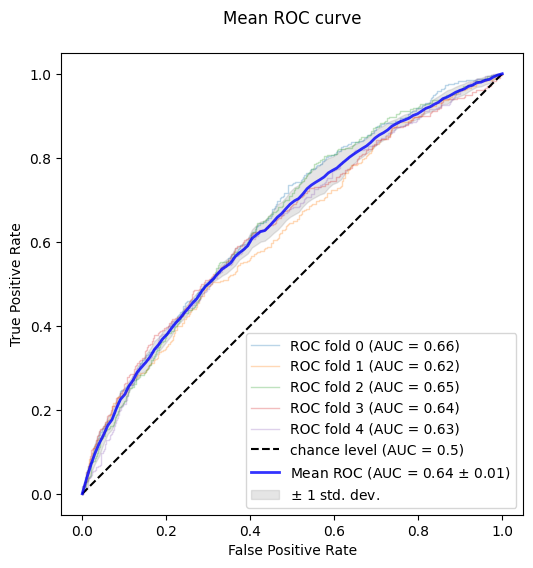


###  ND8CSP12  ### 

There are 202  features.
Accuracy of Logistic regression classifier on training set: 0.7657
Accuracy of Logistic regression classifier on test set: 0.7889 



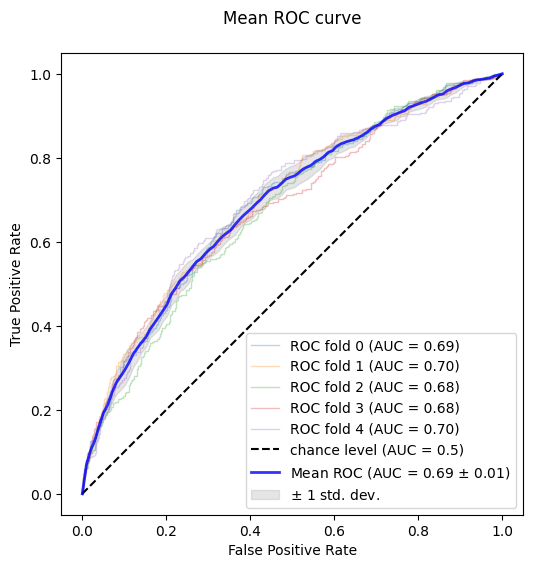


###  ND8MALG  ### 

There are 202  features.
Accuracy of Logistic regression classifier on training set: 0.8610
Accuracy of Logistic regression classifier on test set: 0.8757 



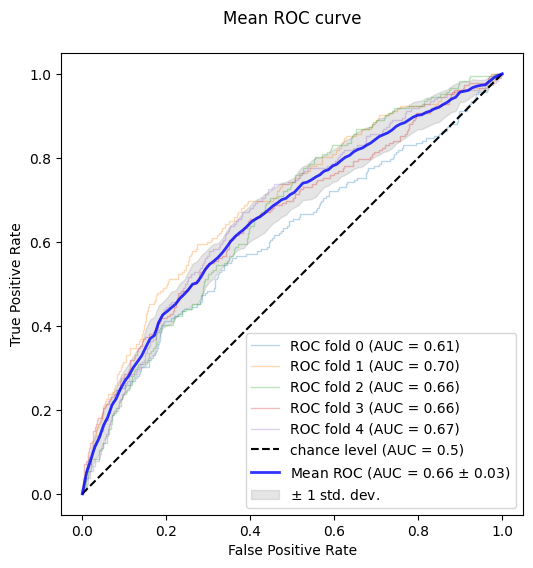

In [26]:
# So the goal is to check if a model predicts better an outcome by including the new variables.

# Model 1 - WEBWEMS
# Model 2 - CASP
# Model 3 - MALAISE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import sem

from sklearn import svm
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

outcomelist = ["ND8WEMWB", "ND8CSP12", "ND8MALG"]

# Creating the list of X values
listvariables = ["WORDCNT", "readability"]
for a in list_absfreq_names[:200]:
    listvariables.append(a)
df_age50_ml = df_age50_analysis[listvariables].copy()

for a in outcomelist:

    ####################################################################################
    print("\n### ", a, " ### \n")
    ####################################################################################

    X = df_age50_ml
    y = df_age50_analysis[a]
    for b in ["WORDCNT", "readability"]:
        X[b] = (X[b] - np.min(X[b])) / (np.max(X[b] - np.min(X[b])))
    num_rows, num_cols = X.shape
    print("There are", num_cols, "features.")
    # print("The ML dataset has", num_cols, "features before adding polynomials.\n")
    # print("The length of the varlist is", len(varlist), "\n")
    # special_X = df_age50_analysis[varlist].copy()
    # poly = PolynomialFeatures(interaction_only = True)
    # special_X = poly.fit_transform(special_X)
    # special_X = pd.DataFrame(special_X)
    # print("The poly dataset has", len(special_X.columns), "features.\n")
    # X = pd.concat([X.reset_index(drop=True), special_X.reset_index(drop=True)], axis = 1)
    # print("The ML dataset has", len(X.columns), "features after adding polynomials, before removing duplicates.\n")
    # X = X.T.drop_duplicates().T
    # print("The ML dataset has", len(X.columns), "features after adding polynomials, after removing duplicates.\n")

    # for x in range(191):
    #     X = X.rename(columns = {x : "interaction_{}".format(x)})
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    clf = LogisticRegression(C = 0.01, max_iter = 10000).fit(X_train, y_train)
                    
    print('Accuracy of Logistic regression classifier on training set: {:.4f}'
         .format(clf.score(X_train, y_train)))
    print('Accuracy of Logistic regression classifier on test set: {:.4f} \n'
         .format(clf.score(X_test, y_test)))
    
    # Permutation test can be done here:
    # https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
    
    # Copied from there:
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    
    cv = StratifiedKFold(n_splits=5)
    classifier = LogisticRegression(C = 0.01, max_iter = 10000)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve\n",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()




# 4. ANALYSES AT AGE 62 in 2021

In [61]:
df_age62 = pd.read_csv("covid-19_wave3_survey_cls.tab.txt", sep='\t', lineterminator='\r', low_memory=False)
df_age62 = df_age62[df_age62["CW3_COHORT"] == 1]

print("Before dropping missing cases, there are", len(df_age62), "NCDS participants in CW3.\n")
# ID
df_age62["NCDSID"] = df_age62["NCDSID"].str.findall("N[\w]*").astype(str)
df_age62["NCDSID"] = df_age62["NCDSID"].str.replace("[", "")
df_age62["NCDSID"] = df_age62["NCDSID"].str.replace("'", "")
df_age62["NCDSID"] = df_age62["NCDSID"].str.replace("]", "")

varlist = ["NCDSID", "CW3_COMBWT",
           "CW3_GAD2PHQ2_1", "CW3_GAD2PHQ2_2", "CW3_GAD2PHQ2_3", "CW3_GAD2PHQ2_4",
           "CW3_MALAISE_1", "CW3_MALAISE_2", "CW3_MALAISE_3", "CW3_MALAISE_4", "CW3_MALAISE_5",
           "CW3_MALAISE_6", "CW3_MALAISE_7", "CW3_MALAISE_8", "CW3_MALAISE_9"]

df_age62 = df_age62[varlist]

varlist = ["CW3_GAD2PHQ2_1", "CW3_GAD2PHQ2_2", "CW3_GAD2PHQ2_3", "CW3_GAD2PHQ2_4",
           "CW3_MALAISE_1", "CW3_MALAISE_2", "CW3_MALAISE_3", "CW3_MALAISE_4", "CW3_MALAISE_5",
           "CW3_MALAISE_6", "CW3_MALAISE_7", "CW3_MALAISE_8", "CW3_MALAISE_9"]

for x in varlist:
    df_age62.loc[df_age62[x] == -1, x] = np.nan
    df_age62.loc[df_age62[x] == -8, x] = np.nan
    df_age62.loc[df_age62[x] == -9, x] = np.nan

df_age62 = df_age62.dropna()

for x in varlist:
    df_age62[x] = df_age62[x] - 1

df_age62["CW3_GAD"] = df_age62["CW3_GAD2PHQ2_1"] + df_age62["CW3_GAD2PHQ2_2"]
df_age62.loc[df_age62["CW3_GAD"] <= 2, "CW3_GAD"] = 0
df_age62.loc[df_age62["CW3_GAD"] >= 3, "CW3_GAD"] = 1

df_age62["CW3_PHQ"] = df_age62["CW3_GAD2PHQ2_3"] + df_age62["CW3_GAD2PHQ2_4"]
df_age62.loc[df_age62["CW3_PHQ"] <= 2, "CW3_PHQ"] = 0
df_age62.loc[df_age62["CW3_PHQ"] >= 3, "CW3_PHQ"] = 1

malaise = ["CW3_MALAISE_1", "CW3_MALAISE_2", "CW3_MALAISE_3", "CW3_MALAISE_4", "CW3_MALAISE_5",
           "CW3_MALAISE_6", "CW3_MALAISE_7", "CW3_MALAISE_8", "CW3_MALAISE_9"]

for x in malaise:
    df_age62.loc[df_age62[x] == 1, x] = 2
    df_age62.loc[df_age62[x] == 0, x] = 1
    df_age62.loc[df_age62[x] == 2, x] = 0
    
df_age62["CW3_MALAISE"] = (df_age62["CW3_MALAISE_1"] +
                           df_age62["CW3_MALAISE_2"] +
                           df_age62["CW3_MALAISE_3"] +
                           df_age62["CW3_MALAISE_4"] +
                           df_age62["CW3_MALAISE_5"] +
                           df_age62["CW3_MALAISE_6"] +
                           df_age62["CW3_MALAISE_7"] +
                           df_age62["CW3_MALAISE_8"] +
                           df_age62["CW3_MALAISE_9"])
df_age62.loc[df_age62["CW3_MALAISE"] <= 3, "CW3_MALAISE"] = 0
df_age62.loc[df_age62["CW3_MALAISE"] >= 4, "CW3_MALAISE"] = 1

df_age62 = df_age62.drop(varlist, axis=1)
print("After dropping missing cases, there are", len(df_age62), "NCDS participants in CW3. \n")

df_age62_analysis = pd.merge(df_age50_analysis, df_age62, on = "NCDSID", how = "inner")

df_age62_analysis = df_age62_analysis.dropna()

print("After merging cases, there are", len(df_age62_analysis), "NCDS participants with valid text data and outcomes at CW3.\n")

outcome = ["CW3_GAD", "CW3_PHQ", "CW3_MALAISE"]
for b in outcome:
    prop = (len(df_age62[df_age62[b] == 1]) / len(df_age62)) * 100
    prop = f"{prop:.1f}"
    print("In this sample,", prop, "% of participants had a negative outcome for the variable", b)


Before dropping missing cases, there are 6809 NCDS participants in CW3.

       NCDSID  CW3_COMBWT  CW3_GAD2PHQ2_1  CW3_GAD2PHQ2_2  CW3_GAD2PHQ2_3  \
26    N10056D        -1.0             NaN             NaN             NaN   
91    N10251E        -1.0             1.0             1.0             2.0   
242   N10657Y        -1.0             2.0             1.0             1.0   
304   N10804R        -1.0             1.0             1.0             1.0   
343   N10906W        -1.0             NaN             NaN             NaN   
760   N12007C        -1.0             2.0             1.0             1.0   
1140  N13075U        -1.0             1.0             1.0             1.0   
1412  N13847Q        -1.0             1.0             1.0             1.0   
1723  N14751M        -1.0             2.0             2.0             1.0   
1730  N14778Y        -1.0             1.0             1.0             1.0   
2030  N15550J        -1.0             1.0             1.0             1.0   
205

# 4.2 Inference

In [67]:
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf

outcome = ["CW3_GAD", "CW3_PHQ", "CW3_MALAISE"]
    
for b in outcome:
        
    df_result = pd.DataFrame()
    print("Calculating for outcome:", b, "...\n")
    
    for a in list_absfreq_names[:100]:
        model = smf.logit("{} ~ C(ND8HNVQ) + C(ND8NS3P) + C(ND8SEX) + C(ND8WEMWB) + C(ND8CSP12) + C(ND8MALG) + WORDCNT + readability + {}".format(b, a), data = df_age62_analysis).fit(disp=0)
        model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
        model_odds['p'] = model.pvalues
        model_odds['p'] = model_odds['p'].apply(lambda x : f'{x:.3f}')
        model_odds[['Lower 95CI', 'Upper 95CI']] = np.exp(model.conf_int())
        df_result = pd.concat([df_result, model_odds.loc[a]], axis=1)

    df_result = df_result.T.sort_values(by = "OR", ascending=False)
    print("Top 10 most positive OR values:\n")
    print(df_result[["OR", "p"]][:10])
    print("\nTop 10 most negative OR values:\n")
    print(df_result[["OR", "p"]][-10:])
    print(len(df_result[df_result["p"].astype(float) < 0.05]), "tokens were sig. associated with the outcome at p < 0.05.\n")
    print(len(df_result[df_result["p"].astype(float) < 0.01]), "tokens were sig. associated with the outcome at p < 0.01.\n")
    print(len(df_result[df_result["p"].astype(float) < 0.001]), "tokens were sig. associated with the outcome at p < 0.001.\n")



Calculating for outcome: CW3_GAD ...

Top 10 most positive OR values:

              OR      p
age     1.652562  0.012
well    1.474027  0.018
chang   1.345158  0.226
involv  1.327218  0.265
full    1.314678  0.134
busi    1.305144  0.275
hour    1.291827  0.291
enough  1.276934  0.228
left    1.253468  0.295
around   1.23921  0.358

Top 10 most negative OR values:

                 OR      p
swim       0.771974  0.359
spend      0.750423  0.081
day        0.734376  0.163
week       0.725131  0.173
abl        0.699984  0.035
also       0.620817  0.037
play       0.596013  0.028
regularli  0.546738  0.047
pension    0.465816  0.022
leisur     0.396152  0.019
8 tokens were sig. associated with the outcome at p < 0.05.

0 tokens were sig. associated with the outcome at p < 0.01.

0 tokens were sig. associated with the outcome at p < 0.001.

Calculating for outcome: CW3_PHQ ...

Top 10 most positive OR values:

                OR      p
left      1.597714  0.018
love      1.499895  0.026
f

# GARBAGE
### 1. REMOVING  WORDS PRESENT LESS THAN FIVE TIMES IN TOTAL

### 2. PAST ATTEMPT AT COMPUTING RELATIVE FREQUENCY OF ALL UNIQUE TOKENS.